In [ ]:
# 1. 파이썬 코드에서 Matplotlib 폰트 설정
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import timedelta
from itertools import combinations
from collections import Counter

# 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("한글 폰트 설정이 완료되었습니다.")

# 3. 데이터 로드 및 통합 (모든 문제 풀이의 시작점)
try:
    orders_df = pd.read_csv('../data/orders.csv')
    payments_df = pd.read_csv('../data/payments.csv')
    products_df = pd.read_csv('../data/products.csv')
    shipping_df = pd.read_csv('../data/shipping.csv')
    customers_df = pd.read_csv('../data/customers.csv')

    # 모든 데이터프레임 병합
    df = pd.merge(orders_df, payments_df, on='order_id', how='left')
    df = pd.merge(df, products_df, on='product_id', how='left')
    df = pd.merge(df, customers_df, on='customer_id', how='left')
    df = pd.merge(df, shipping_df, on='order_id', how='left')

    # 데이터 전처리
    date_cols = ['order_date', 'payment_date', 'join_date', 'shipping_start_date', 'shipping_end_date']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    df['total_sales'] = df['quantity'] * df['price']
    
    print("데이터 로드 및 통합이 완료되었습니다.")

except FileNotFoundError as e:
    print(f"파일을 찾을 수 없습니다: {e}")


한글 폰트 설정이 완료되었습니다.
데이터 로드 및 통합이 완료되었습니다.


In [3]:
df.columns

Index(['order_id', 'customer_id', 'product_id', 'order_date', 'quantity',
       'payment_id', 'payment_method', 'payment_status', 'payment_date',
       'product_name', 'category', 'price', 'stock', 'name', 'gender', 'age',
       'join_date', 'city', 'shipping_id', 'shipping_company',
       'shipping_status', 'shipping_start_date', 'shipping_end_date',
       'total_sales'],
      dtype='object')

카테고리별 평균 월별 성장률:   category  growth_rate
6      화장품     0.127811
0       가구     0.098994
3       식품     0.087353
4       의류     0.079554
1       도서     0.078011
2    스포츠용품     0.073715
5     전자제품     0.048982


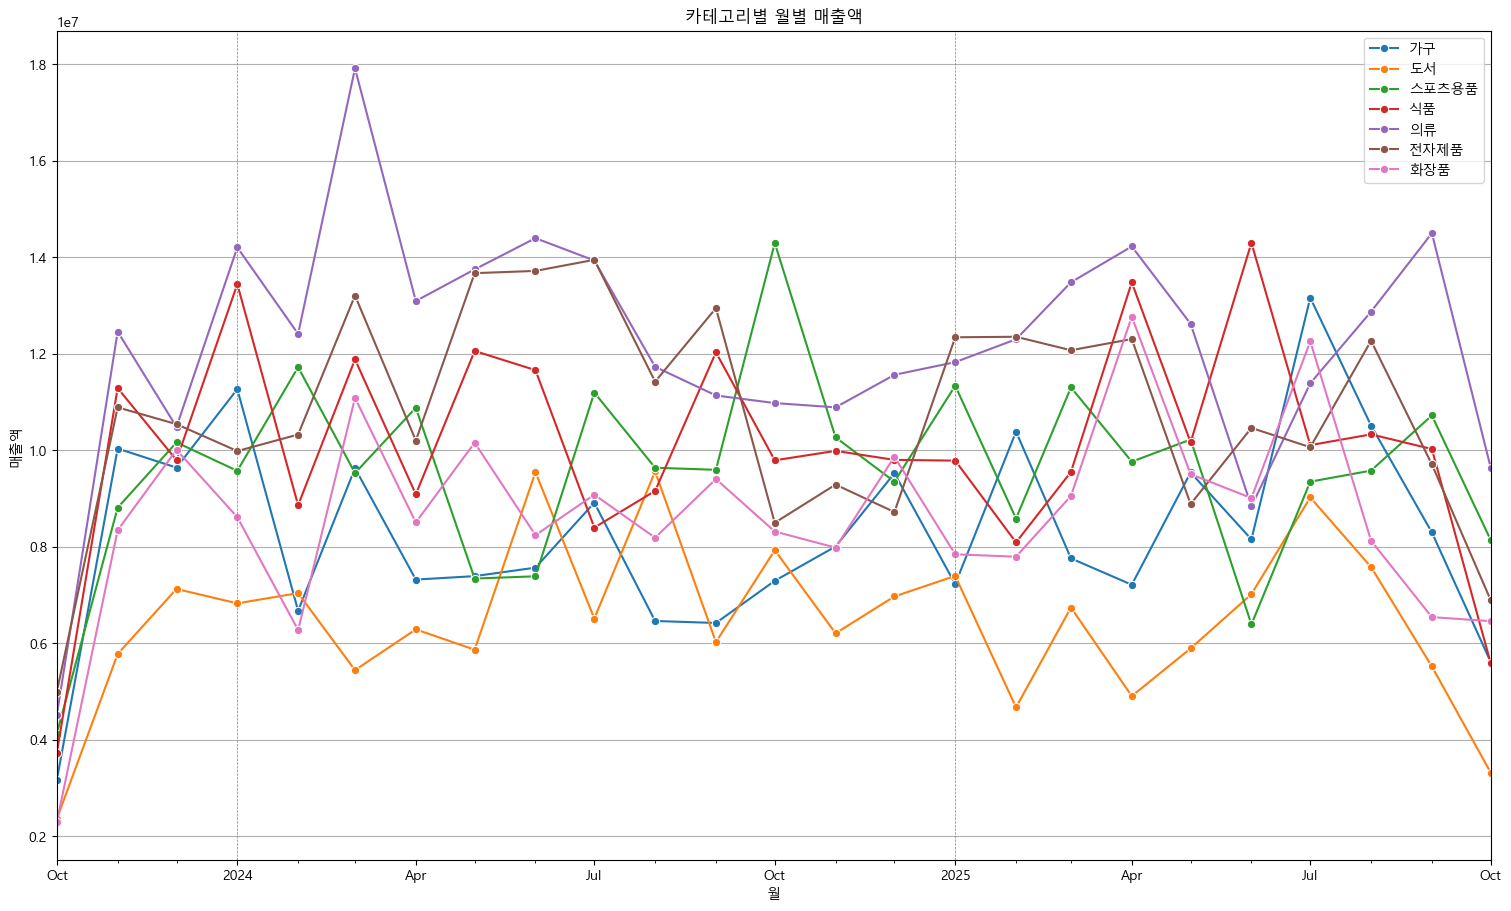

In [4]:
# 문제 1: 카테고리별 월별 매출액 추이를 분석하고, 가장 성장률이 높은 카테고리를 식별하세요
# 시각화: 라인 플롯
from matplotlib.dates import ConciseDateFormatter
import matplotlib.dates as mdates

plt.figure(figsize=(15,9),layout='constrained')

# 데이터 정제
cols=['category','payment_date','order_date','total_sales']
df_data = df[cols].copy()

df_data['year_month'] = df_data['order_date'].dt.to_period('M').dt.to_timestamp()

df_data = df_data.groupby(['category','year_month'])['total_sales'].sum().reset_index()
# 전월 대비 성장률 계산
df_data['growth_rate'] = df_data.groupby('category')['total_sales'].pct_change()

# 평균 성장률 계산 (NaN 제외)
avg_growth_by_category = (
    df_data.dropna(subset=['growth_rate'])
    .groupby('category')['growth_rate']
    .mean()
    .reset_index()
    .sort_values(by='growth_rate', ascending=False)
)

month_df = df_data.pivot_table(index='year_month',columns='category',values='total_sales')

print(f"카테고리별 평균 월별 성장률: {avg_growth_by_category}")

for category in month_df.columns:
    sns.lineplot(
        x=month_df.index,
        y=month_df[category],
        label=category,
        marker='o'
    )

ax = plt.gca()
# ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(
    ConciseDateFormatter(ax.xaxis.get_major_locator())
    # ConciseDateFormatter(mdates.AutoDateLocator())
)

january_ticks = [d for d in month_df.index if d.month == 1]
for tick in january_ticks:
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5)
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.grid(axis='y')

plt.xlim(month_df.index.min(),month_df.index.max())
plt.title('카테고리별 월별 매출액')
plt.xlabel('월')
plt.ylabel('매출액')
plt.show()


In [5]:
# 문제 2: 고객별 재주문까지 걸리는 평균 시간을 분석하고, 가장 재구매 주기가 짧은 충성 고객 TOP 5를 찾으세요.
# 시각화: 바 차트

# 비즈니스 목적: 고객의 재구매 주기를 파악하여, 주기에 맞춘 리마인드 알림이나 프로모션을 통해 고객의 이탈을 방지하고 재구매를 유도합니다

     customer_id  avg_days
457        C0473       1.0
196        C0204       4.0
904        C0940       5.0
389        C0401       5.0
1823       C1892       5.0


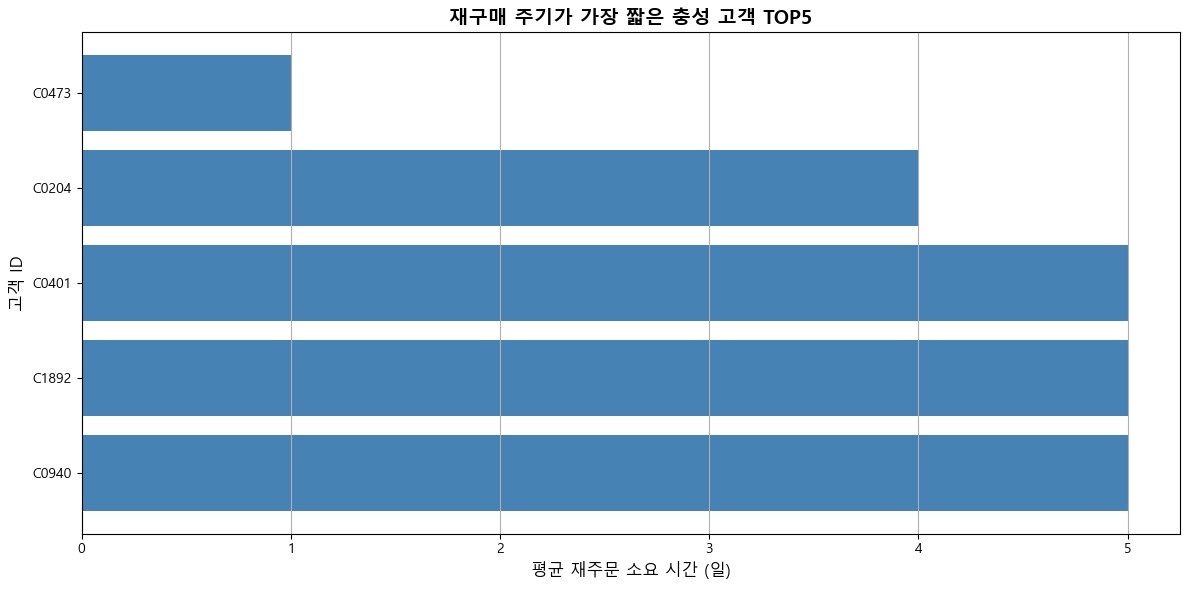

In [6]:
# 데이터 정제
cols=['customer_id','order_date']
df_data2 = (df[cols].copy()
    .sort_values(cols)
    .reset_index(drop=True))
df_data2['days_since_last_order'] = (
    df_data2.groupby('customer_id')['order_date']
    .diff()
    .dt.days
)
summary = (df_data2.dropna(subset=['days_since_last_order'])
    .groupby('customer_id')['days_since_last_order']
    .mean()
    .reset_index(name='avg_days')
    .sort_values('avg_days'))

print(summary.head(5))

top_5 = summary.head(5).sort_values('avg_days', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(top_5['customer_id'], top_5['avg_days'], color='steelblue')
plt.ylabel('고객 ID', fontsize=12)
plt.xlabel('평균 재주문 소요 시간 (일)', fontsize=12)
plt.title('재구매 주기가 가장 짧은 충성 고객 TOP5', fontsize=14, fontweight='bold')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [7]:
# 문제 3: 재구매율이 가장 높은 상위 10개 상품을 찾으세요
# 비즈니스 목적 : 고객 충성도가 높은 상품을 파악하고, 해당 상품의 재고를 안정적으로 관리하거나 충선 고객 대상 마케팅에 활용합니다


In [8]:
# 데이터 정제
cols = ['product_name','customer_id','order_id']
df_data3 = df[cols].copy()

# 상품별 재구매율 계산
product_repeat = df_data3.groupby([ 'product_name']).agg({
    'customer_id': 'nunique',  # 해당 상품을 구매한 고객 수
    'order_id': 'count'  # 총 주문 수
}).reset_index()

product_repeat.columns = ['product_name', 'unique_customers', 'total_orders']

# 재구매율 계산: (총 주문 수 - 고유 고객 수) / 고유 고객 수
repeat_orders = product_repeat['total_orders'] - product_repeat['unique_customers']
product_repeat['repeat_rate'] = (repeat_orders / product_repeat['unique_customers'])

# 정렬 (재구매율 높은 순)
product_repeat_sorted = product_repeat[['product_name','repeat_rate']].sort_values('repeat_rate', ascending=False)

product_repeat_sorted.head(10)

,product_name,repeat_rate
151,스포츠용품 상품_107,0.090909
22,가구 상품_2,0.066667
333,의류 상품_441,0.066667
204,스포츠용품 상품_498,0.062500
86,도서 상품_103,0.062500
490,화장품 상품_490,0.058824
449,화장품 상품_262,0.058824
306,의류 상품_265,0.058824
481,화장품 상품_422,0.055556
498,화장품 상품_8,0.055556


In [9]:
# 문제 4: 카테고리 내에서 각 상품의 매출액 순위를 계산하고, 카테고리별 상위 3개 상품을 확인하세요
# 비즈니스 목적: 각 카테고리의 핵심 상품(Key Item)과 비주력 상품을 파악하여 상품 진열, 프로모션, 재고 관리에 활용합니다

# 데이터 정제
cols = ['product_name','category','total_sales']
df_data4 = df[cols].copy()
product_total_sales = df_data4.groupby(['category','product_name']).agg({
    'total_sales' : 'sum',
}).reset_index()
product_total_sales['rank'] = (product_total_sales
                                .groupby('category')['total_sales']
                                .rank(method='dense', ascending=False))
top3_with_rank = product_total_sales[product_total_sales['rank'] <= 3].sort_values(['category', 'rank'])

print("\n카테고리별 매출 상위 3개 상품:")
print(top3_with_rank)


카테고리별 매출 상위 3개 상품:
    category  product_name  total_sales  rank
4         가구     가구 상품_382      6860700   1.0
44        가구   전자제품 상품_273      6623000   2.0
57        가구    화장품 상품_323      6123000   3.0
70        도서     도서 상품_360      7355400   1.0
74        도서      도서 상품_83      6828800   2.0
112       도서     화장품 상품_82      6683000   3.0
141    스포츠용품   스포츠용품 상품_61      8710000   1.0
146    스포츠용품     식품 상품_173      7522900   2.0
151    스포츠용품     식품 상품_473      7260100   3.0
198       식품      가구 상품_46      9682200   1.0
216       식품  스포츠용품 상품_482      6859800   2.0
238       식품   전자제품 상품_280      6697500   3.0
344       의류   전자제품 상품_463      8091900   1.0
315       의류     식품 상품_396      7265700   2.0
347       의류    화장품 상품_224      6907500   3.0
377     전자제품     도서 상품_391      9197700   1.0
399     전자제품     의류 상품_145      8109000   2.0
413     전자제품   전자제품 상품_218      7281600   3.0
458      화장품  스포츠용품 상품_376      8261600   1.0
469      화장품     식품 상품_329      7087600   2.0
434      화장품  

In [10]:
# 문제 5: 재고가 10개 미만으로 남은 상품 중, 최근 30일간 판매량이 가장 많았던 상품 5개를 찾아 긴급 재고 확보 우선순위를 정하세요
# 비즈니스 목적: 품절로 인한 판매 기회 손실을 최소화하기 위해, 시급하게 재고를 확보해야 할 상품을 결정합니다

# 데이터 정제 
cols = ['product_id','product_name','quantity','stock','order_date']
df_data5 = df.copy()

# 최근 30일 데이터 필터링
df_recent = df_data5[df_data5['order_date'] >= (df_data5['order_date'].max() - pd.Timedelta(days=30))]

# 재고 10개 미만인 상품만 선택 (상품별 최신 재고 정보)
latest_stock = df_data5.groupby('product_id').agg({
    'product_name': 'first',
    'category': 'first',
    'stock': 'last',
}).reset_index()

low_stock_products = latest_stock[latest_stock['stock'] < 10]['product_id'].unique()

df_low_stock_recent = df_recent[df_recent['product_id'].isin(low_stock_products)]

sales_summary = df_low_stock_recent.groupby(['product_id', 'product_name', 'category']).agg({
    'quantity': 'sum',  # 총 판매 수량
}).reset_index()

sales_summary = sales_summary.sort_values('quantity', ascending=False)
print('긴급 재고 확보 필요 상품 TOP 5:')
print(sales_summary[['product_name','quantity']].head(5))

긴급 재고 확보 필요 상품 TOP 5:
    product_name  quantity
3      식품 상품_125         9
13    화장품 상품_437         8
10     식품 상품_367         6
7      식품 상품_289         5
9   스포츠용품 상품_328         5


In [11]:
# 문제 6: 월별 판매량 상위10%에 속하는 상품들의 카테고리 분포 변화를 추적하세요
# 시각화: 누적 영역 차트

# 비즈니스 목적: 시장 트렌드 변화를 파악하고, 어떤 종류의 상품들이 인기를 얻고 있는지 시간에 따른 변화를 관찰합니다

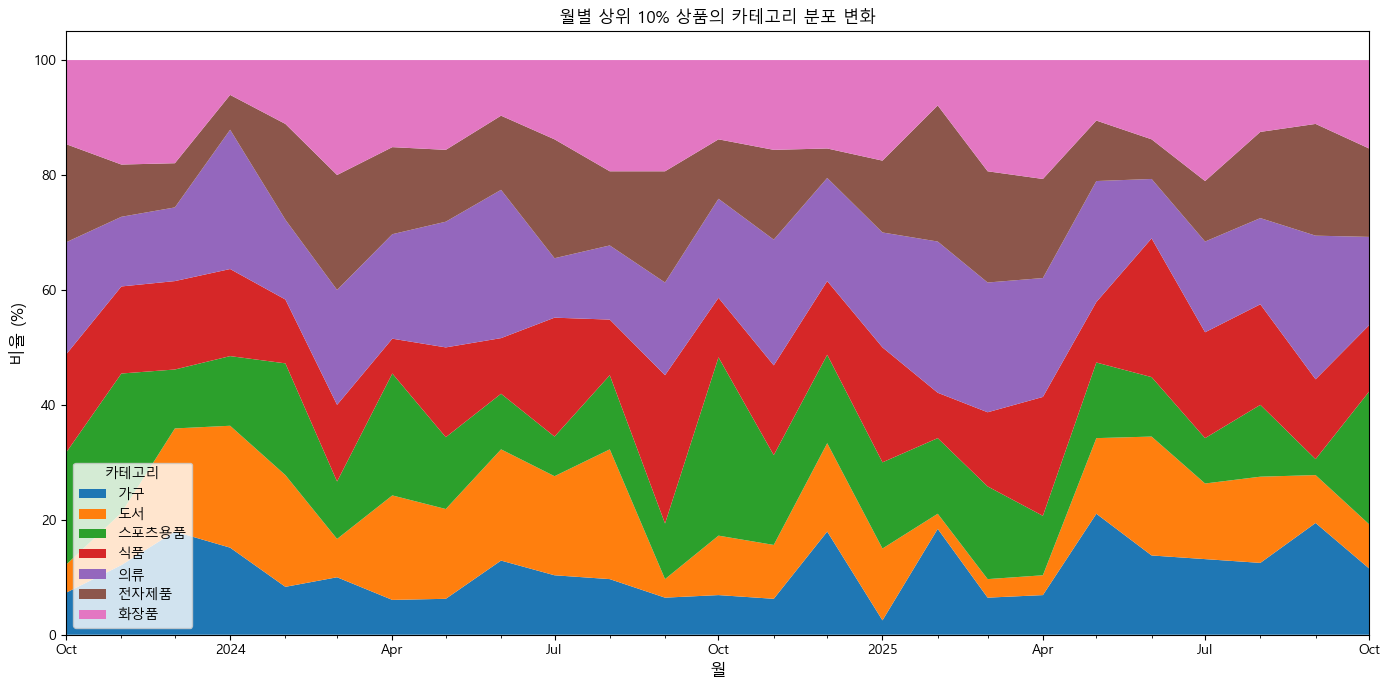

In [12]:
# 데이터 정제
cols = ['category', 'order_date', 'quantity', 'product_id']
df_data6 = df[cols].copy()
df_data6['year_month'] = df_data6['order_date'].dt.to_period('M')

# 월별, 상품별 판매량 집계
monthly_product_sales = df_data6.groupby(['year_month', 'product_id', 'category']).agg({
    'quantity': 'sum',
}).reset_index()

# 각 월별로 상위 10% 상품 선택
top_10_percent_products = []

for month in sorted(monthly_product_sales['year_month'].unique()):
    month_data = monthly_product_sales[monthly_product_sales['year_month'] == month].copy()
    
    # 판매량 기준 상위 10% 임계값
    threshold = month_data['quantity'].quantile(0.9)
    
    # 상위 10%에 속하는 상품
    top_products = month_data[month_data['quantity'] >= threshold].copy()
    
    top_10_percent_products.append(top_products)

top_10_df = pd.concat(top_10_percent_products, ignore_index=True)

# 월별 카테고리 분포 계산
category_distribution = top_10_df.groupby(['year_month', 'category']).agg({
    'product_id': 'count',
    'quantity': 'sum',
}).reset_index()

category_distribution.columns = ['month', 'category', 'product_count', 'total_quantity']

# 월별 비율 계산
monthly_totals = category_distribution.groupby('month')['product_count'].sum().reset_index()
monthly_totals.columns = ['month', 'month_total']

category_distribution = category_distribution.merge(monthly_totals, on='month')
category_distribution['percentage'] = (category_distribution['product_count'] / category_distribution['month_total']) * 100
category_distribution['month_dt'] = category_distribution['month'].dt.to_timestamp()
# 시각화
pivot_data = category_distribution.pivot(index='month_dt', columns='category', values='percentage').fillna(0)
pivot_data = pivot_data.sort_index()

fig, ax = plt.subplots(figsize=(14, 7))

# x축: 0부터 시작하는 숫자 인덱스
x = pivot_data.index

# 스택 영역 차트
ax.stackplot(x, *[pivot_data[col].values for col in pivot_data.columns], 
             labels=pivot_data.columns)
ax.xaxis.set_major_formatter(ConciseDateFormatter(mdates.AutoDateLocator()))

# x축 설정
ax.set_xlim(x.min(), x.max())
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

# 레이블 및 제목
ax.set_xlabel('월', fontsize=12)
ax.set_ylabel('비율 (%)', fontsize=12)
ax.set_title('월별 상위 10% 상품의 카테고리 분포 변화')

# 범례를 좌측 아래에 배치
ax.legend(title='카테고리', loc='lower left')

plt.tight_layout()
plt.show()

In [13]:
# 문제 7: 고객의 첫 구매 상품과 두 번째 구매 상품 카테고리 간의 전환 패턴을 분석하세요
# 시각화: 히트맵

# 비즈니스 목적: 고객의 구매 여정을 이해하고, 첫 구매 상품에 따라 다음 구매를 유도할 상품 추천 전략을 수립합니다

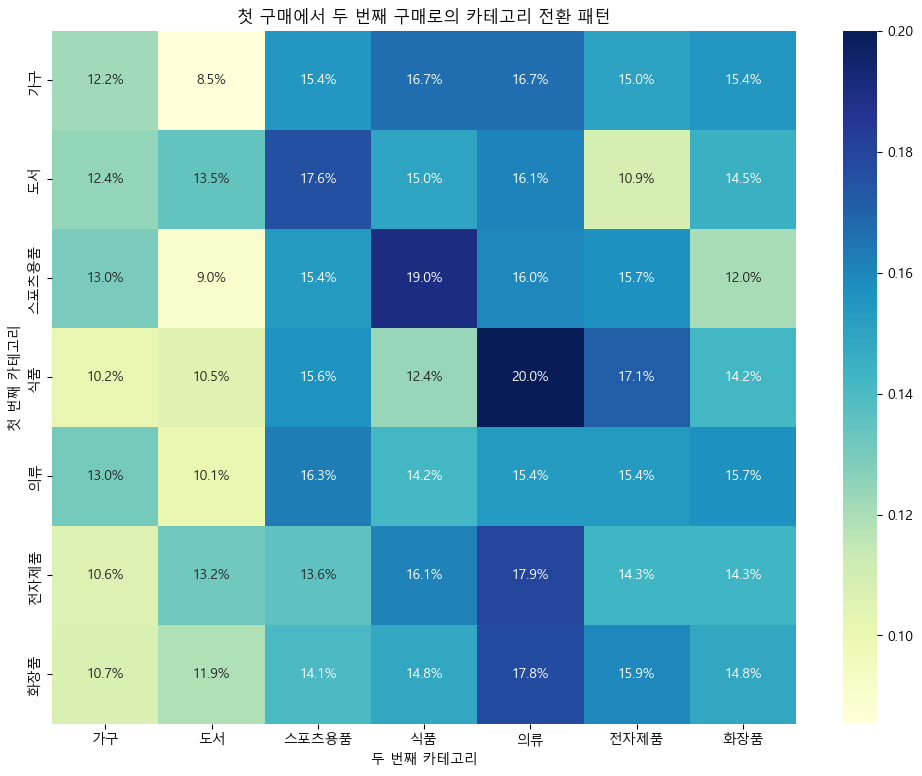

In [14]:
# 데이터 정제
cols = ['category','order_date','customer_id','product_id']
df_data7 = df[cols].copy()

df_sorted = df_data7.sort_values(['order_date','customer_id'])
df_sorted['purchase_num'] = df_sorted.groupby('customer_id').cumcount()+1

first_purchases = df_sorted[df_sorted['purchase_num'] == 1][['customer_id', 'category', 'order_date']]
first_purchases.columns = ['customer_id', 'first_category', 'first_order_date']

second_purchases = df_sorted[df_sorted['purchase_num'] == 2][['customer_id', 'category', 'order_date']]
second_purchases.columns = ['customer_id', 'second_category', 'second_order_date']

# 3. 첫 번째와 두 번째 구매 병합
transition_df = pd.merge(first_purchases, second_purchases, on='customer_id', how='inner')

transition_percentage = pd.crosstab(
    transition_df['first_category'], 
    transition_df['second_category'],
    normalize='index'
)

plt.figure(figsize=(12,9))
annot_labels = (transition_percentage*100).round(1).astype(str)+ '%'
sns.heatmap(transition_percentage,cmap='YlGnBu', annot=annot_labels, fmt='')

plt.title('첫 구매에서 두 번째 구매로의 카테고리 전환 패턴')
plt.xlabel('두 번째 카테고리')
plt.ylabel('첫 번째 카테고리')
plt.show()

In [15]:
# 문제 8: 주문이 가장 많이 발생하는 시간대와 해당 시간대에 가장 잘 팔리는 상품 카테고리를 분석하세요
# 비즈니스 목적: 시간 기반 타켓 마케팅 전약(예: 점심시간 쿠폰, 퇴근길 푸시 알림)을 수집하는 데 활용합니다

시간대별 카테고리별 판매 수량:
category      가구   도서  스포츠용품    식품    의류  전자제품   화장품
time_period                                         
심야(00-05)    778  655   1048  1080  1059   961   922
오전(05-12)    993  948   1411  1291  1536  1239  1177
오후(12-18)    911  824   1094  1172  1324  1053   990
저녁(18-24)    929  832   1104  1096  1372  1184  1022


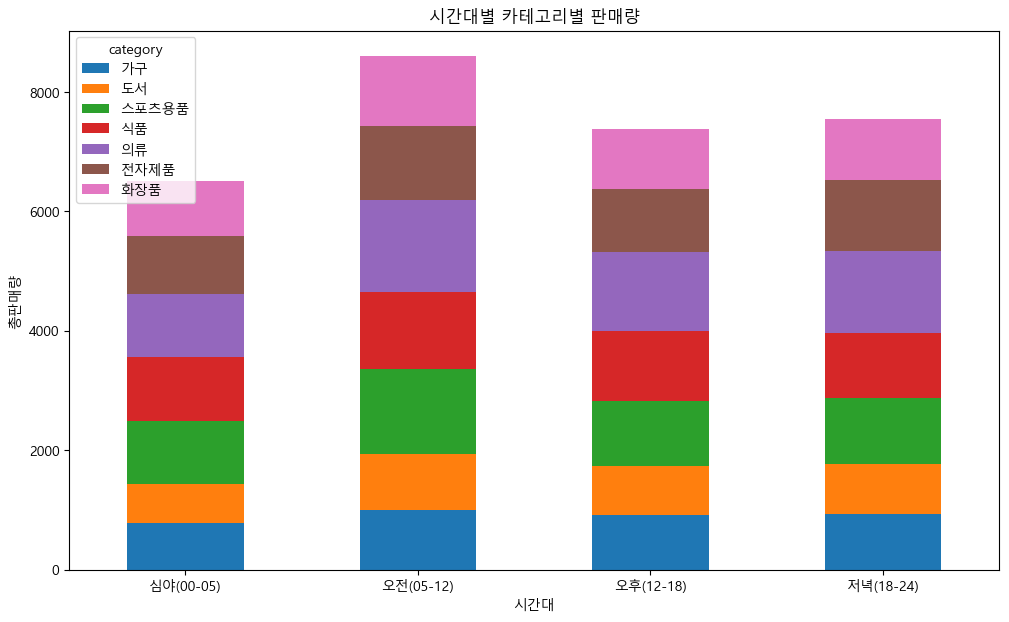

In [16]:
# 데이터 정제
cols = ['category','order_date','quantity']
df_data8 = df[cols].copy()

df_data8['order_hour'] = df_data8['order_date'].dt.hour

# 시간대 분류 함수
def classify_time_period(hour):
    if 0 <= hour < 5:
        return '심야(00-05)'
    elif 5 <= hour < 12:
        return '오전(05-12)'
    elif 12 <= hour < 18:
        return '오후(12-18)'
    else:  # 18 <= hour < 24
        return '저녁(18-24)'

df_data8['time_period'] = df_data8['order_hour'].apply(classify_time_period)

time_stats = df_data8.groupby(['time_period','category']).agg({'quantity':'sum'})

# Stacked Bar 그래프를 위한 데이터 재구조화
# unstack()을 사용하여 category를 열로 변환
time_stats_pivot = time_stats.unstack(fill_value=0)
time_stats_pivot.columns = time_stats_pivot.columns.droplevel(0)  # 'quantity' 레벨 제거

# 시간대 순서 정렬
time_period_order = ['심야(00-05)', '오전(05-12)', '오후(12-18)', '저녁(18-24)']
time_stats_pivot = time_stats_pivot.reindex(time_period_order)

print("시간대별 카테고리별 판매 수량:")
print(time_stats_pivot)

# ===== 그래프 1: 기본 Stacked Bar (수량) =====
fig, ax = plt.subplots(figsize=(12, 7))
time_stats_pivot.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    width=0.5
)
ax.set_title('시간대별 카테고리별 판매량')
ax.set_xlabel('시간대')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_ylabel('총판매량')
ax.legend(title='category')
ax.tick_params(axis='x')

In [17]:
# 문제 9: 신규 고객과 기존 고객이 주로 구매하는 상품 카테고리에 차이가 있는지 비교 분석 하세요
# 비즈니스 목적: 고객 유형에 따른 상품 추천 전략을 세우고, 신규 고객에게는 진입장벽이 낮은 상품을, 기존 고객에게는 새로운 카테고리의 상품을 제안하는 등의 전략

신규/기존 고객의 카테고리별 구매 비중 (%)
category          가구         도서      스포츠용품         식품         의류       전자제품  \
cust_type                                                                     
기존고객       12.063351  10.832676  15.398855  15.539406  17.671660  14.668678   
신규고객       11.031175  11.870504  19.784173  12.709832  16.306954  18.944844   

category         화장품  
cust_type             
기존고객       13.825375  
신규고객        9.352518  


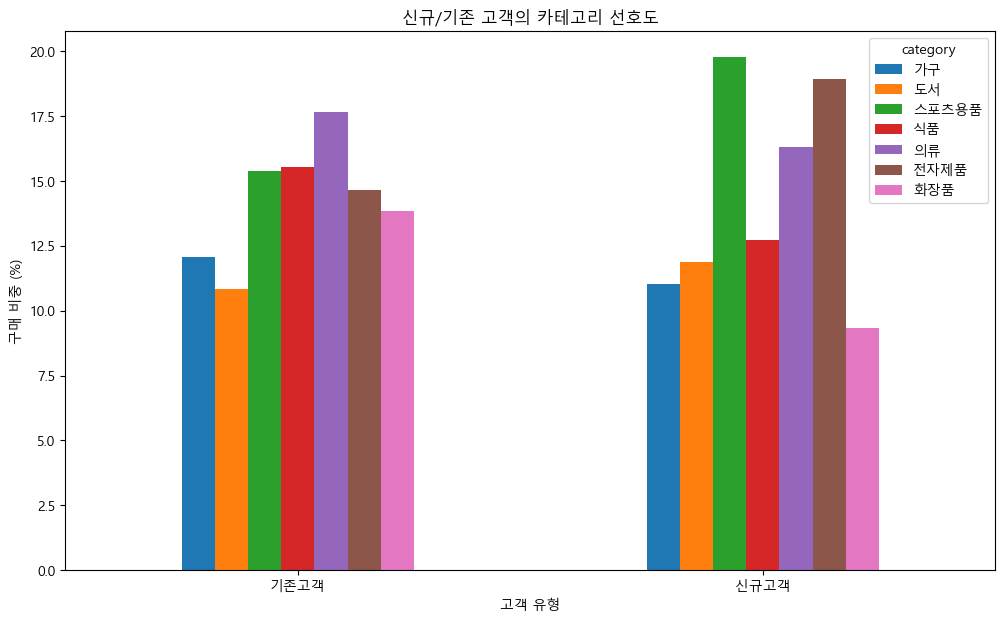

In [18]:
# 데이터 정제
cols = ['order_date','join_date','category','customer_id','quantity']
df_data9 = df[cols].copy()

df_data9['order_year_month'] = df_data9['order_date'].dt.to_period('M')
df_data9['join_year_month'] = df_data9['join_date'].dt.to_period('M')

df_data9['cust_type'] = np.where(df_data9['join_year_month']==df_data9['order_year_month'],'신규고객','기존고객')

cust_type_data = pd.crosstab(
    df_data9['cust_type'], 
    df_data9['category'],
    values=df_data9['quantity'],
    aggfunc= 'sum',
    normalize='index'
)

print('신규/기존 고객의 카테고리별 구매 비중 (%)')
print(cust_type_data*100)

fig, ax = plt.subplots(figsize=(12, 7))
cust_type_data.plot(
    kind='bar',
    ax=ax,
    rot=0
)
ax.set_title('신규/기존 고객의 카테고리 선호도')
ax.set_xlabel('고객 유형')
ax.set_ylabel('구매 비중 (%)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.1f}'))
plt.show()

In [19]:
# 문제 10: 주문 취소가 가장 빈번한 상품 상위 5개를 찾고, 이들 상퓸의 공통적인 특징을 분석하세요.
# 비즈니스 목적: 취소율이 높은 상품의 원인을 파악(예: 불충분한 상품 설명, 높은 가격)하여 운영 효율성을 개선하고 매출 손실을 줄입니다.

In [20]:
# 데이터 정제
cols = ['product_name','category','payment_status','stock','price']
df_data10 = df[cols].copy()

canceled_product = df_data10.groupby('product_name').agg(failed_count=('payment_status', lambda s: (s == 'Pending').sum())).sort_values('failed_count', ascending=False)

print('주문 취소(결제 대기)가 잦은 상품 TOP 5:')
print(canceled_product.head(5))

sorted_product = canceled_product.head(5).index.tolist()

product_characteristics = df_data10[df_data10['product_name'].isin(sorted_product)].groupby('product_name').agg(
    category=('category','first'),
    avg_price=('price', 'mean'),
    avg_stock=('stock', 'mean'),
)

print('\n해당 상품들의 특징 :')
print(product_characteristics)


주문 취소(결제 대기)가 잦은 상품 TOP 5:
              failed_count
product_name              
화장품 상품_160               5
전자제품 상품_159              4
의류 상품_132                4
화장품 상품_256               4
스포츠용품 상품_6               4

해당 상품들의 특징 :
             category  avg_price  avg_stock
product_name                               
스포츠용품 상품_6        화장품    74300.0        2.0
의류 상품_132          식품     6600.0       39.0
전자제품 상품_159        식품    57500.0       32.0
화장품 상품_160      스포츠용품    51600.0        5.0
화장품 상품_256         도서    16500.0       24.0


In [21]:
# 문제 11: 상품명에 특정 키워드가 포함된 상품들의 평균 가격과 다른 상품들의 평균 가격을 비교하세요.
# -특정 키워드 : '스포츠 용품' 
# 비즈니스 목적: 상품 네이밍 전략이 가격 책정에 미치는 영향을 간접적으로 분석하고, 프리미엄 라인업 등의 키워드 전략을 평가합니다

In [22]:
# 데이터 정제
cols=['product_name','price']
df_data11 = df[cols].copy()

df_data11['splited_name'] = df_data11['product_name'].str.split(' ',expand=True)[0]

avg_price_product_name = df_data11.groupby('splited_name').agg(avg_price=('price','mean'))
avg_price_other_name = df_data11[df_data11['splited_name'] != '스포츠용품']['price'].mean()

sports_avg = avg_price_product_name.loc['스포츠용품'].mean()

print(f"'스포츠용품'포함 상품 평균 가격: {sports_avg:,.0f}원")
print(f"그 외 상품 평균 가격: {avg_price_other_name:,.0f}원")

'스포츠용품'포함 상품 평균 가격: 56,466원
그 외 상품 평균 가격: 54,679원


In [23]:
# 문제 12: 월별 매출액과 해당 월의 신규 상품 출시 수 간의 상관관계를 분석하세요
# 비즈니 목적: 신상품 출시라는 비즈니 활동이 매출 성과에 얼마나 긍정적인 영향을 미치는지 정량적으로 파악합니다.

In [ ]:
# 데이터 정제
cols=['product_id','order_date','total_sales']
df_data12 = df[cols].copy()
# product_id 순서를 출시 순서로 가정하여 가상의 출시일 생성
products_sorted_df = df_data12.sort_values('product_id').reset_index(drop=True)
# 첫 주문일부터 마지막 주문일까지의 기간을 상품 수만큼 균등하게 나누어 출시일 부여
products_sorted_df['launch_dates'] = pd.to_datetime(np.linspace(df['order_date'].min().value, df['order_date'].max().value, len(products_sorted_df)))

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 

,product_id,order_date,total_sales,launch_dates
0,P0001,2023-11-04 14:28:25,186400,2023-10-20 09:41:43.000000000
1,P0001,2025-06-21 06:52:46,233000,2023-10-20 11:26:53.043604480
2,P0001,2024-05-27 10:09:50,46600,2023-10-20 13:12:03.087208704
3,P0001,2025-04-20 02:03:49,186400,2023-10-20 14:57:13.130813184
4,P0001,2024-05-08 19:05:33,139800,2023-10-20 16:42:23.174417408
...,...,...,...,...
9995,P0500,2025-01-27 18:51:36,364400,2025-10-19 08:49:48.825582592
9996,P0500,2024-09-15 03:59:49,182200,2025-10-19 10:34:58.869186816
9997,P0500,2024-07-30 16:46:17,91100,2025-10-19 12:20:08.912791296
9998,P0500,2024-02-03 13:59:38,91100,2025-10-19 14:05:18.956395520
